In [3]:
"""CREATED 8/14"""
import numpy as np
import pandas as pd
from itertools import *
import matplotlib
import re
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.api as sm
import scipy.stats as stats
pd.options.mode.chained_assignment = None
matplotlib.rcParams['figure.figsize'] = (10,5)
sns.set()

In [4]:
#Load data
#Datafile
filename = 'data/rawdata_screen3_7-28.csv'
print 'Reading %s...'%filename
df = pd.read_csv(filename)
#Compound annotation file
cdf = pd.read_csv('data/screen3_smiles.named.CID.KID.target.csv')

Reading data/rawdata_screen3_7-28.csv...


In [5]:
#Process data
#Remove internal controls
df = df[~df.strain.isin(['intcon1','intcon2'])]

#Replace zero counts
df['count'] = df['count'].replace(0,1)

#Sum counts from different sequenings
strainInWell_cols = ['strain','compound','concentration','plate_name','row','column']
df = df.groupby(strainInWell_cols)['count'].sum().reset_index()

##Calulate fraction per well
#Group by unique identifiers
unique_cols = ['plate_name','row','column']
#Calculate total counts/well
df = df.merge(df.groupby(unique_cols)['count'].sum().rename('tot').reset_index())
#Calculate fraction per well
df['frac'] = df['count']/df.tot

#Log transform fractions
df['lf'] = np.log10(df.frac)

#Column for compound-concentration combo
df['compcon'] = df['compound'] +'_'+ df.concentration.astype(str)

#Rank concentrations for each compound
def concrank(x):
    concs = np.array([round(i,1) for i in x]) #Round to nearest tenth
    conc_dict = {np.unique(concs)[i]:int(i) for i in range(len(np.unique(concs)))}
    return pd.DataFrame({'rank':[conc_dict[i] for i in concs]}).set_index(x.index)
df = df.join(df.groupby('compound').concentration.apply(concrank))

#Name replicates
def repenum(x):
    #Enumerate the replicates for each group
    plates = x.unique()
    rep_dict = {plates[i]:'rep_%s'%i for i in range(len(plates))}
    return pd.DataFrame({'rep':[rep_dict[i] for i in x]}).set_index(x.index)
df = df.join(df.groupby(['compound','concentration']).plate_name.apply(repenum))

#Add compound names
df = df.merge(cdf[['compound_id','compound_name']].rename(columns={'compound_id':'compound'}))

#Compound id -> compound name dictionary
id2name = dict(zip(cdf.compound_id,cdf.compound_name))
name2id = {v:k for k,v in id2name.items()} #Name-> id

#Df for untreated
untreated = df[df['compound']=='untreated']

#Add standard deviations for each strain
df = df.merge(untreated.groupby('strain').lf.std().rename('std_lf').reset_index())

#Different model fitting approaches
def onefit(untreated,df,formula='frac ~ plate_name:strain'):
    #One model for all strains
    model = smf.ols(formula,untreated).fit()
    df['effect'] = model.predict(df)
    return df
def sepfit(untreated,df,formula='frac ~ plate_name'):
    #Separate model for each strain
    models = {strain:smf.ols(formula,untreated[untreated.strain==strain]).fit() for strain in df.strain.unique()}
    df['effect'] = 0
    for strain in df.strain.unique():
        df.effect[df.strain==strain] = models[strain].predict(df[df.strain==strain])
    return df

#Batch correction
df = sepfit(untreated,df,formula='lf ~ plate_name')

# #Back to not-log space
# df.effect = np.exp(df.effect)
df['corrected'] = df.lf - df.effect

#Normalized residual
df['normed'] = df.corrected/df.std_lf

#P-value calculation
def pval(x):
    #Two-tail
#     ps = pd.DataFrame({'pval': np.min([stats.norm.cdf(x,0,null_std),stats.norm.sf(x,0,null_std)],axis=0)*2}).set_index(x.index)
    #One-tail
    ps = pd.DataFrame({'pval':stats.norm.cdf(x,0,null_std)}).set_index(x.index)
    return ps
null_std = df.corrected[df['compound']=='untreated'].std()
cols = list(df.columns)
df = df[cols].join(df.groupby('strain').corrected.apply(pval))
#Rename pvalue column for comparison
df = df.rename(columns={'pval':'me_p'})

"""Compare to Eachan's data"""
eachan = pd.read_csv('data/screen3.csv')
#Subset Eachan's data to the compounds included in my subset
eachan = eachan[eachan['compound'].isin(df['compound'].unique())&eachan.strain.isin(df.strain.unique())]
#Categorize concentrations
eachan = eachan.rename(columns={'p.value':'eachan_p'}) 

#Create new df with Eachan's data
df = df.merge(eachan[['compound','concentration','strain','eachan_p']],how='outer')
df = df.merge(cdf[['compound_name','target']]) #Add targets to df

#Drop any duplicates
df = df.drop_duplicates()

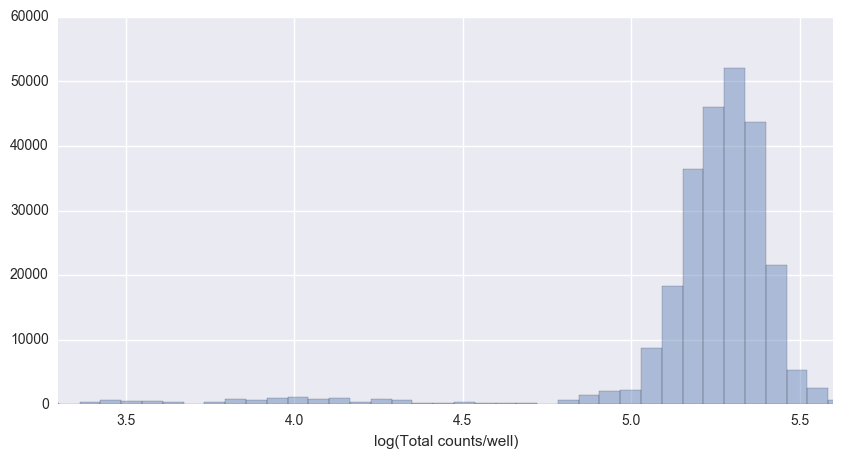

In [76]:
"""
Distribution of total counts per well
"""
data = np.log10(df.tot[df.tot.notnull()])
sns.distplot(data,kde=False)
plt.xlim([3.3,5.6])
plt.xlabel('log(Total counts/well)')
plt.show()

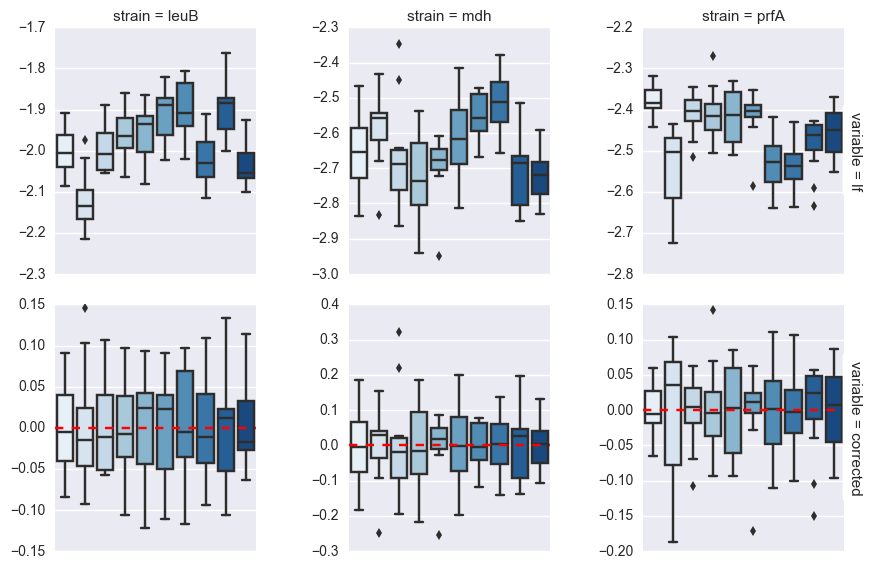

strain
leuB    1.650932e-15
mdh     8.202651e-07
prfA    7.722629e-12
dtype: float64


In [53]:
"""
Variability from plate to plate before and after batch correction
"""
#Choose a strain
strains = np.random.choice(df.strain.unique(),3)
# strains = ['leuB','mdh','prfA']
data = df[(df['compound']=='untreated')&df.strain.isin(strains)]
#Prepare data for melting
#Need to pass: strain, measurement type (log-fraction or corrected), plate_name
melted = pd.melt(data,['strain','plate_name'],['lf','corrected'])
g = sns.FacetGrid(data=melted,col='strain',row='variable',sharey=False,margin_titles=True)
#Plot boxplots
g.map(sns.boxplot,'plate_name','value',palette='Blues')
def addline(data,**kwargs):
    #Add horizontal line to corrected
    if data.variable.unique()[0] == 'corrected':
        plt.axhline(c='red',ls='--')
g.map_dataframe(addline)
g.set_xticklabels([])
plt.show()
#Perform ANOVA for each strain by plate and calculate p value
def applyanova(group):
    #Apply type 2 ANOVA on all plates from a group of untreated conditions for a given strain
    anova = sm.stats.anova_lm(smf.ols('lf~plate_name',data=group).fit(),typ=2)
    return anova['PR(>F)'].loc['plate_name']
print data.groupby('strain').apply(applyanova)

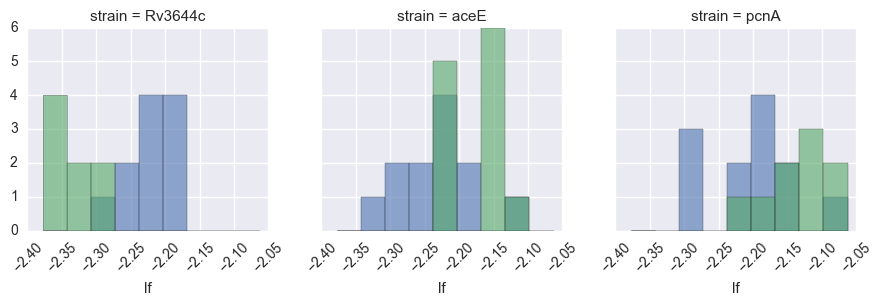

strain
Rv3644c    8.947747e-07
aceE       9.235628e-03
pcnA       1.901441e-03
dtype: float64


In [102]:
"""
Batch culprit: it's the plates
"""
plates = np.random.choice(df.plate_name[df.plate_name.notnull()].unique(),3)
data = df[df.plate_name.isin(plates)]
strains = np.random.choice(df.strain.unique(),3)
data =  data[(data['compound']=='untreated')&(data.strain.isin(strains))]
g = sns.FacetGrid(data=data,col='strain',hue='plate_name') #Use row for paper
bins = np.linspace(data.lf.quantile(0.05),data.lf.quantile(0.95),10)
g.map(plt.hist,'lf',bins=bins,alpha=0.6)
g.set_xticklabels(rotation=45)
plt.show()
#Apply two-sample t test
def applytwosample(group):
    #Apply two sample t-test
    plates = group.plate_name.unique()
    data = [group.lf[group.plate_name==p] for p in plates]
    return stats.ttest_ind(data[0],data[1])[1]
print data.groupby('strain').apply(applytwosample)

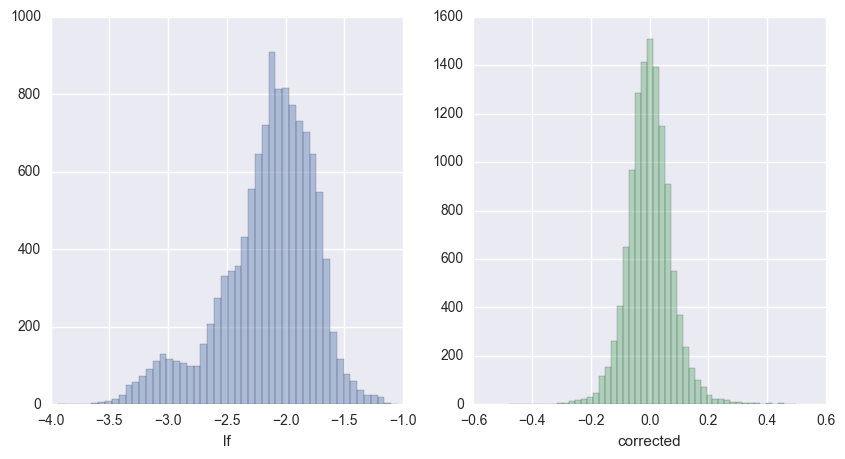

In [39]:
"""
Untreated profile before and after
"""
unt = df[df['compound']=='untreated']
fig,axs = plt.subplots(ncols=2)
sns.distplot(unt.lf,kde=False,ax=axs[0])
sns.distplot(unt.corrected,kde=False,ax=axs[1],bins=np.linspace(-.5,.5,50),color=sns.color_palette()[1])
plt.show()

BRD-K58819470-001-03-4 2-thiouracil AB00017482.5


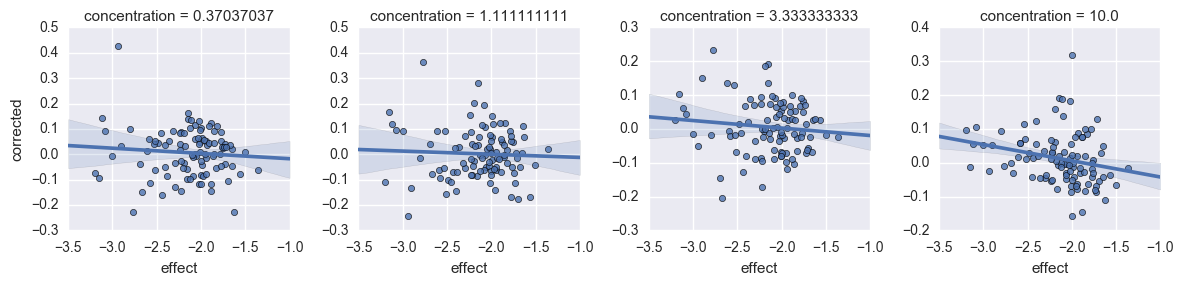

concentration
0.370370     0.025634
1.111111     0.042791
3.333333     0.009599
10.000000    0.001996
dtype: float64


In [113]:
"""
Correlation between effect and residual of treated condition
"""
#Choose compound 
# comp = np.random.choice(df['compound'].unique())
comp = name2id['2-thiouracil']
data = df[df['compound']==comp]
plates = data.plate_name.unique()
#Select single plate
data = data[data.plate_name==plates[0]]
g = sns.FacetGrid(data=data,col='concentration',sharex=False,sharey=False) #Use row for paper
g.map(sns.regplot,'effect','corrected',scatter_kws={'edgecolor':'black','linewidth':0.5})
print comp,id2name[comp],plates[0]
plt.show()
def applyr2(group):
    #Calculate correlation coefficient between effect and corrected for each concentration
    lf,cor = group.lf,group.corrected
    return stats.pearsonr(lf,cor)[0]**2
    
print data.groupby('concentration').apply(applyr2)

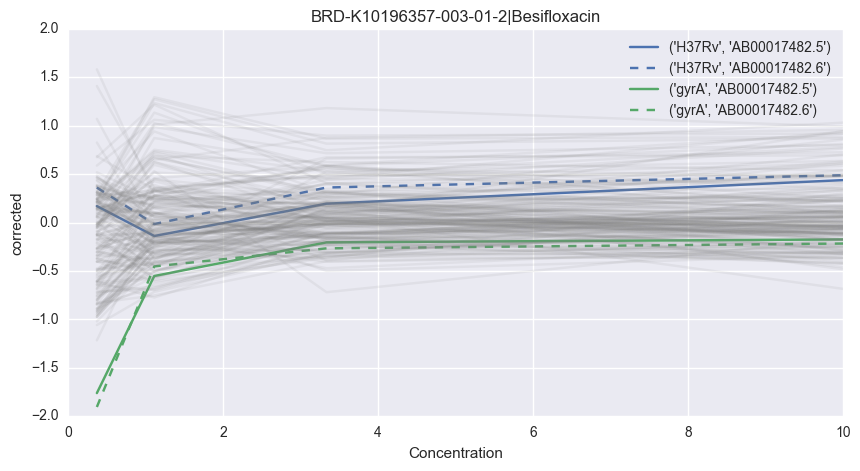

In [10]:
"""
Dose response of gyrA with Besifloxacin
"""
def doses(comp=None,strains=[],var='normed'):
    #Plot dose response of compound 'comp' and color 'strains' for 'var'
    #Iterators for styling
    colors = cycle(sns.color_palette())
    styles = cycle(['-','--'])
    
    if type(strains) == str:
        strains = [strains]
    if not comp:
        comp = np.random.choice(df['compound'].unique())
    want = ['H37Rv']+strains
    data = df[df['compound']==comp]
    
    for strain in data.strain.unique():
        color,alpha,label,ls = 'gray',0.1,None,'-' #Default style
        if strain in want:
            color,alpha = colors.next(),1 #If strain of interest, choose the next color
        for plate in data.plate_name.unique():
            if strain in want:
                label,ls = (strain,plate),styles.next() #For each replicate, change the label and the style
            d = data[(data.strain==strain)&(data.plate_name==plate)]
            plt.errorbar(d.concentration,d[var],c=color,alpha=alpha,label=label,ls=ls)
    plt.xlabel('Concentration')
    plt.ylabel(var)

    plt.legend()
    plt.title('%s|%s'%(comp,id2name[comp]))
    plt.show()
doses(comp=name2id['Besifloxacin'],strains='gyrA',var='corrected')

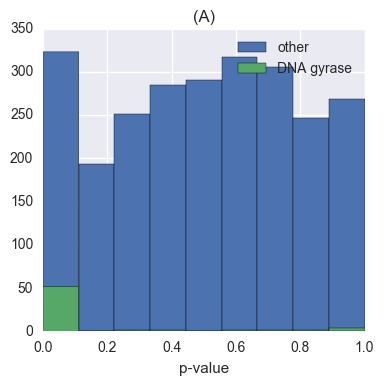

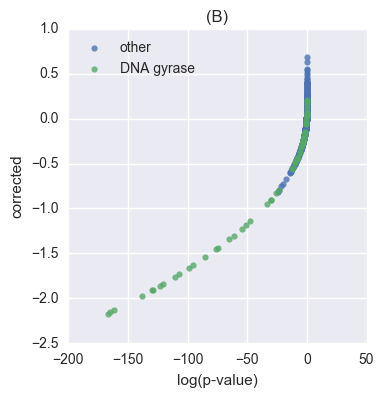

In [133]:
"""
Distribution of pvalues for gyrA
"""
strain = 'gyrA'
var = 'me_p'
data = df[df.strain==strain]
want = ['DNA gyrase']
data['label'] = [t if t in want else 'other' for t in data.target]
g = sns.FacetGrid(data=data,row='strain',hue='label',size=4,sharey=False)
bins = np.linspace(0,1,10)
g.map(plt.hist,var,bins=bins)
plt.xlabel('p-value')
plt.legend()
plt.title('(A)')
"""
pvalue vs. corrected?
"""
data[var] = np.log10(data[var])
want = ['DNA gyrase']
data['label'] = [t if t in want else 'other' for t in data.target]
sns.lmplot(var,'corrected',data=data,hue='label',fit_reg=False,legend_out=False,size=4)
plt.legend(loc='upper left')
plt.xlabel('log(p-value)')
plt.title('(B)')
plt.show()

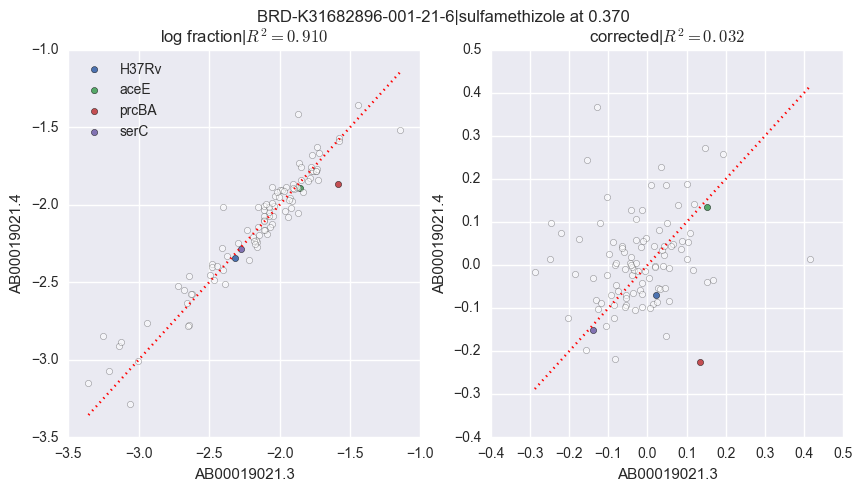

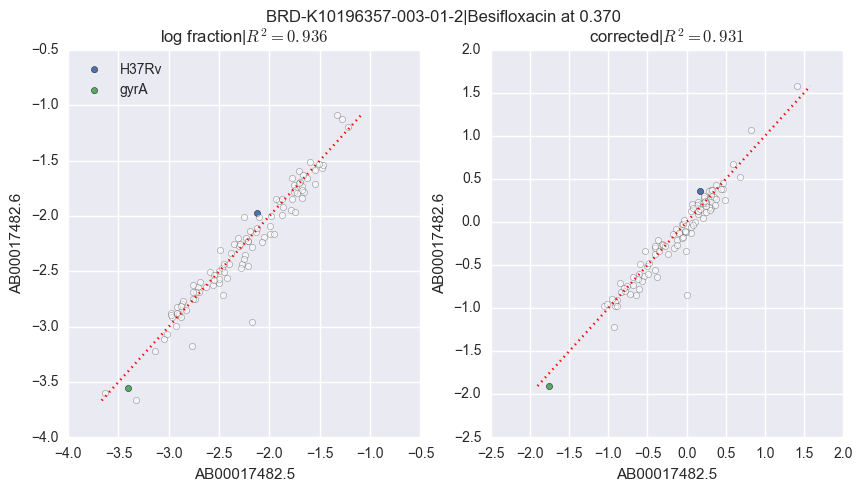

In [102]:
"""
Compound scatter before and after correction
Shows accuracy (closeness to line) and strength of effect (magnitude)
"""
def compoundScatter(comp=None,conc=None,rank=None,var='normed',strains=[]):
    #Static plot of replicates of all strains for a given compound-concentration
    if not comp:
        cc = np.random.choice(df.compcon.unique())
    else:
        if comp in df.compound_name.unique():
            comp = name2id[compound]
        if not conc:
            concs = df[df['compound']==comp].concentration.unique()
            if rank!=None: 
                conc = concs[rank]
            else: 
                conc = np.random.choice(concs)
            cc = comp+'_'+str(conc)
    data = df[df.compcon==cc]
    plates = data.plate_name.unique()      
    if len(plates) != 2:
        return "%s plates! Can't draw scatter"%(len(plates))

    lf = data.pivot('strain','plate_name','lf')#Pivotted log fraction
    cor = data.pivot('strain','plate_name',var)#Pivotted corrected/residual

    fig,axs = plt.subplots(ncols=2,sharex=False,sharey=False)

    #Plot data
    #colors
    if type(strains) is str:
        strains = [strains]
    want = ['H37Rv']+strains
    labels = [s if s in want else None for s in lf.index]
    col_iter = cycle(sns.color_palette())
    col_dict = {s:col_iter.next() if s in want else 'white' for s in data.strain.unique()}
    
    #Log fraction plot
    for strain in lf.index:
        label,alpha = None,0.5
        if strain in want: 
            label,alpha = strain,1
        axs[0].scatter(lf[plates[0]].loc[strain],lf[plates[1]].loc[strain],label=label,alpha=alpha,c=col_dict[strain])
    axs[0].legend(loc='upper left')
    axs[0].plot([lf.min().min(),lf.max().max()],[lf.min().min(),lf.max().max()],ls=':',c='red')
    axs[0].set_xlabel(plates[0])
    axs[0].set_ylabel(plates[1])
    slope, intercept, r_value, p_value, std_err = stats.linregress(lf[plates[0]],lf[plates[1]])
    axs[0].set_title('log fraction|$R^2=%.3f$'%r_value**2)

    #Variable plot
    for strain in cor.index:
        label,alpha = None,0.5
        if strain in want: 
            label,alpha = strain,1
        axs[1].scatter(cor[plates[0]].loc[strain],cor[plates[1]].loc[strain],label=label,alpha=alpha,c=col_dict[strain])
    axs[1].plot([cor.min().min(),cor.max().max()],[cor.min().min(),cor.max().max()],ls=':',c='red')
    axs[1].set_xlabel(plates[0])
    axs[1].set_ylabel(plates[1])
    slope, intercept, r_value, p_value, std_err = stats.linregress(cor[plates[0]],cor[plates[1]])
    axs[1].set_title('%s|$R^2=%.3f$'%(var,r_value**2))

    cid = data['compound'].unique()[0]
    cname = data.compound_name.unique()[0]
    conce = data.concentration.unique()[0]

    plt.suptitle('%s|%s at %.3f'%(cid,cname,conce))
    plt.show()
compoundScatter(var='corrected',comp=name2id['sulfamethizole'],strains=['aceE','serC','prcBA'],rank=0)
compoundScatter(var='corrected',comp=name2id['Besifloxacin'],strains='gyrA',rank=0)

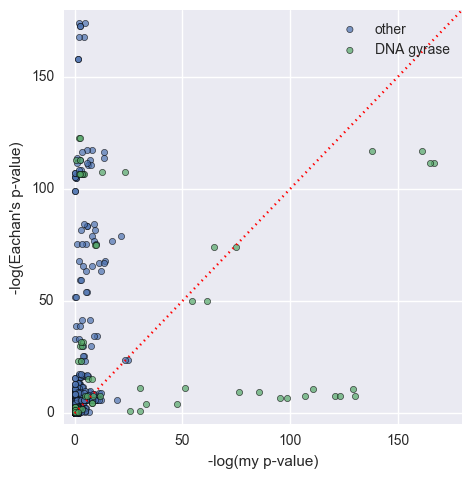

In [130]:
"""
Comparing pvalues between me and Eachan
"""
strain = 'gyrA'
data = df[df.strain==strain]
data.me_p = -np.log10(data.me_p)
data.eachan_p = -np.log10(data.eachan_p)
want = ['DNA gyrase']
data['label'] = [t if t in want else 'other' for t in data.target]
sns.lmplot('me_p','eachan_p',data,'label',fit_reg=False,legend_out=False,
           scatter_kws={'edgecolor':'black','linewidth':.5,'alpha':.7})
plt.xlim(-5,180)
plt.ylim(-5,180)
# plt.xlim(-180,5)
# plt.ylim(-180,5)
plt.xlabel('-log(my p-value)')
plt.ylabel("-log(Eachan's p-value)")
plt.plot([0,180],[0,180],ls=':',c='red')
plt.legend()
plt.show()

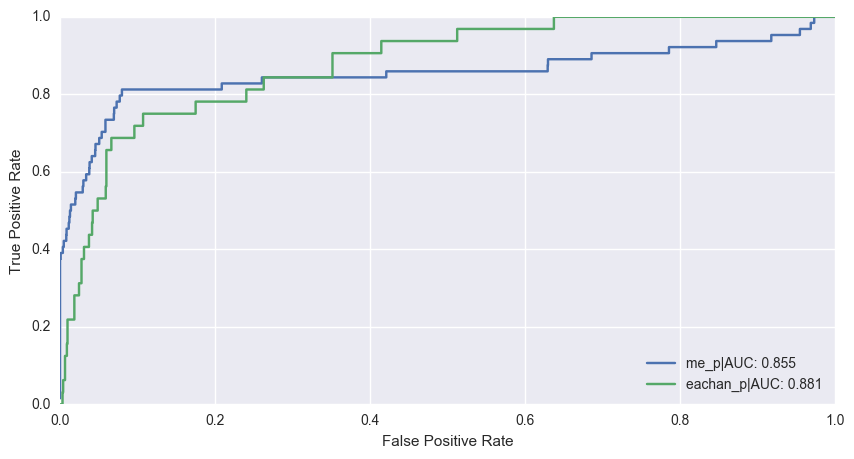

In [22]:
def ROC(df,var):
    data = df[[var,'label']][df.notnull()].sort_values(by=var)
    ns = data.groupby('label').size()
    tp = []
    fp = []
    tp_counter = 0
    fp_counter = 0
    for l in data.label:
        if l == 'DNA gyrase':
            tp_counter += 1
        else:
            fp_counter += 1
        tp.append(float(tp_counter)/ns.loc['DNA gyrase'])
        fp.append(float(fp_counter)/ns.loc['other'])
    AUC = np.trapz(tp,fp)
    plt.plot(fp,tp,label='%s|AUC: %.3f'%(var,AUC))
strain = 'gyrA'
data = df[df.strain==strain]
# data.me_p = np.log10(data.me_p)
# data.eachan_p = np.log10(data.eachan_p)
want = ['DNA gyrase']
data['label'] = [t if t in want else 'other' for t in data.target]
ROC(data,'me_p')
ROC(data,'eachan_p')
plt.legend(loc='lower right')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

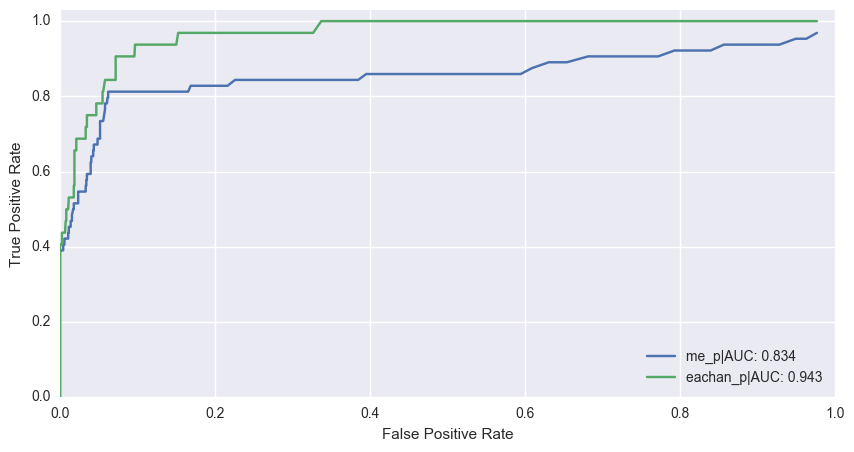

In [8]:
"""
Compare ROC against same sliding threshold
"""
def compareROC(data,v1,v2):
    #!!Takes a while
    #Compare two ROC curves against the same increments 
    #s1,s2: series 1 and series 2
    data = data.dropna()
    data[v1] = np.log10(data[v1])
    data[v2] = np.log10(data[v2])
    
    s1 = data[[v1,'label']].sort_values(by=v1)
    s2 = data[[v2,'label']].sort_values(by=v2)
    combo = pd.concat([s1[v1],s2[v2]]).drop_duplicates().sort_values()
    smallest = np.min(combo.diff())
    if smallest < 1e-2:
        smallest = 1e-2
    #Discrimination threshold vector
    steps = np.arange(min(combo),max(combo),smallest)
    
    #Initialize arrays for s1 and s2
    tp1,fp1,tp2,fp2 = [],[],[],[]
    
    #Total number of true and false
    ns = {'true':data.label.sum(),'false':len(data)-data.label.sum()}
    #Compute ROC
    for s in steps:
        #How many values are less than threshold?
        less1 = s1[s1[v1]<s]
        less2 = s2[s2[v2]<s]
        
        #Counts of how many true positives and false positives
        tp_c1 = less1.label.sum()
        fp_c1 = len(less1) - tp_c1
        
        tp_c2 = less2.label.sum()
        fp_c2 = len(less2) - tp_c2
    
        #Calculate fraction tp/fp at given threshold
        tp1.append(tp_c1/float(ns['true']))
        fp1.append(fp_c1/float(ns['false']))
        
        tp2.append(tp_c2/float(ns['true']))
        fp2.append(fp_c1/float(ns['false']))
        
    #Integrate both curves
    AUC1 = np.trapz(tp1,fp1)
    AUC2 = np.trapz(tp2,fp2)
    #Plot
    plt.plot(fp1,tp1,label='%s|AUC: %.3f'%(v1,AUC1))
    plt.plot(fp2,tp2,label='%s|AUC: %.3f'%(v2,AUC2))
    plt.legend(loc='lower rtight')
    plt.ylim(0,1.03)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show()
        
strain = 'gyrA'
want = ['DNA gyrase']
data = df[df.strain==strain].dropna()
data['label'] = [True if t in want else False for t in data.target]
compareROC(data,'me_p','eachan_p')